# How to preprocess UMI count data with analytic Pearson residuals

With version `1.9`, scanpy introduces new preprocessing functions based on Pearson residuals into the `experimental.pp` module. These functions implement the core steps of the preprocessing described and benchmarked in [Lause et al. (2021)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7). 

In the first part, this tutorial introduces the new core functions by demonstrating their usage on two example datasets. In the second part, we briefly explain the optional arguments and their default settings. Finally, two wrapper functions that run the whole Pearson residual workflow at once are briefly discussed.


## Background

In brief, Pearson residuals transform raw UMI counts into a representation where three aims are achieved:

- remove the technical variation that comes from differences in total counts between cells

- stabilize the mean-variance relationship across genes, i.e. ensure that biological signal from both low and high expression genes can contribute similarly to downstream processing

- genes that are homogenously expressed (like housekeeping genes) have small variance, while genes that are differentially expressed (like marker genes) have high variance

Thus, computing Pearson residuals replace the common steps of explicitly normalizing by sequencing depth and log-transforming the data for variance stabilization.

The analytic Pearson residuals presented here are similar to Seurat's `scTransform` model ([Hafemeister & Satija, 2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)), but use a simplified model that allows an analytic solution. See [Lause et al. (2021)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7) for details.

#### Preparations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.0.dev151+gca65af52.d20220228 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.0 pandas==1.3.1 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


Install `leidenalg` dependency if needed:

In [2]:
#!pip3 install leidenalg

#### Download data
This tutorial uses two 10X datasets that are processed in parallel:

- the [3k PBMC (v1 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k) dataset
- the [10k PBMC (v3 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3?) dataset

Uncomment this cell to create directories, download and unpack the data:

In [3]:
# !mkdir tutorial_data
# !mkdir tutorial_data/pbmc3k_v1
# !mkdir tutorial_data/pbmc10k_v3

# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O tutorial_data/pbmc3k_v1.tar.gz
# !cd tutorial_data; tar -xzf pbmc3k_v1.tar.gz -C pbmc3k_v1 --strip-components 2

# !wget https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz -O tutorial_data/pbmc10k_v3.tar.gz
# !cd tutorial_data; tar -xzf pbmc10k_v3.tar.gz -C pbmc10k_v3 --strip-components 1

#### Load data
Here we load the two downloaded datasets from disk and create `AnnData` objects for them.

In [4]:
adata_pbmc3k = sc.read_10x_mtx("tutorial_data/pbmc3k_v1/", cache=True)
adata_pbmc10k = sc.read_10x_mtx("tutorial_data/pbmc10k_v3/", cache=True)

adata_pbmc3k.uns["name"] = "PBMC 3k (v1)"
adata_pbmc10k.uns["name"] = "PBMC 10k (v3)"

... reading from cache file cache/tutorial_data-pbmc3k_v1-matrix.h5ad
... reading from cache file cache/tutorial_data-pbmc10k_v3-matrix.h5ad


To demonstrate that Pearson residuals select meaningful genes on these PBMC datasets, we will compare the gene selection to a set of marker genes that were identified in the [PBMC3k tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). They map to PBMC cell types as follows:
```
['IL7R',            # CD4 T cells
 'LYZ', 'CD14',     # CD14+ Monocytes
 'MS4A1',           # B cells
 'CD8A',            # CD8 T cells
 'GNLY', 'NKG7',    # NK cells
 'FCGR3A', 'MS4A7', # FCGR3A+ Monocytes
 'FCER1A', 'CST3',  # Dendritic Cells
 'PPBP']            # Megakaryocytes

```

A good gene selection should include these differentially expressed genes.

In [5]:
# marker genes from table in pbmc3k tutorial
markers = [
    "IL7R",
    "LYZ",
    "CD14",
    "MS4A1",
    "CD8A",
    "GNLY",
    "NKG7",
    "FCGR3A",
    "MS4A7",
    "FCER1A",
    "CST3",
    "PPBP",
]

## Perform Quality control
First, we remove cells and genes with few counts, then remove outlier cells. Parameters and thresholds are inspired from [the PBMC3k tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

#### Basic filtering

In [6]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    adata.var_names_make_unique()
    print(adata.uns["name"], ": data shape:", adata.shape)
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

PBMC 3k (v1) : data shape: (2700, 32738)
filtered out 19024 genes that are detected in less than 3 cells
PBMC 10k (v3) : data shape: (11769, 33538)
filtered out 232 cells that have less than 200 genes expressed
filtered out 13246 genes that are detected in less than 3 cells


#### Compute quality control metrics
We compute number of deteced genes per cell, total counts per cell and percentage of mitochondrial genes per cell.

In [7]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )

#### Plot quality control metrics

We plot all metrics and observe that both datasets have some outlier cells.

PBMC 3k (v1) :


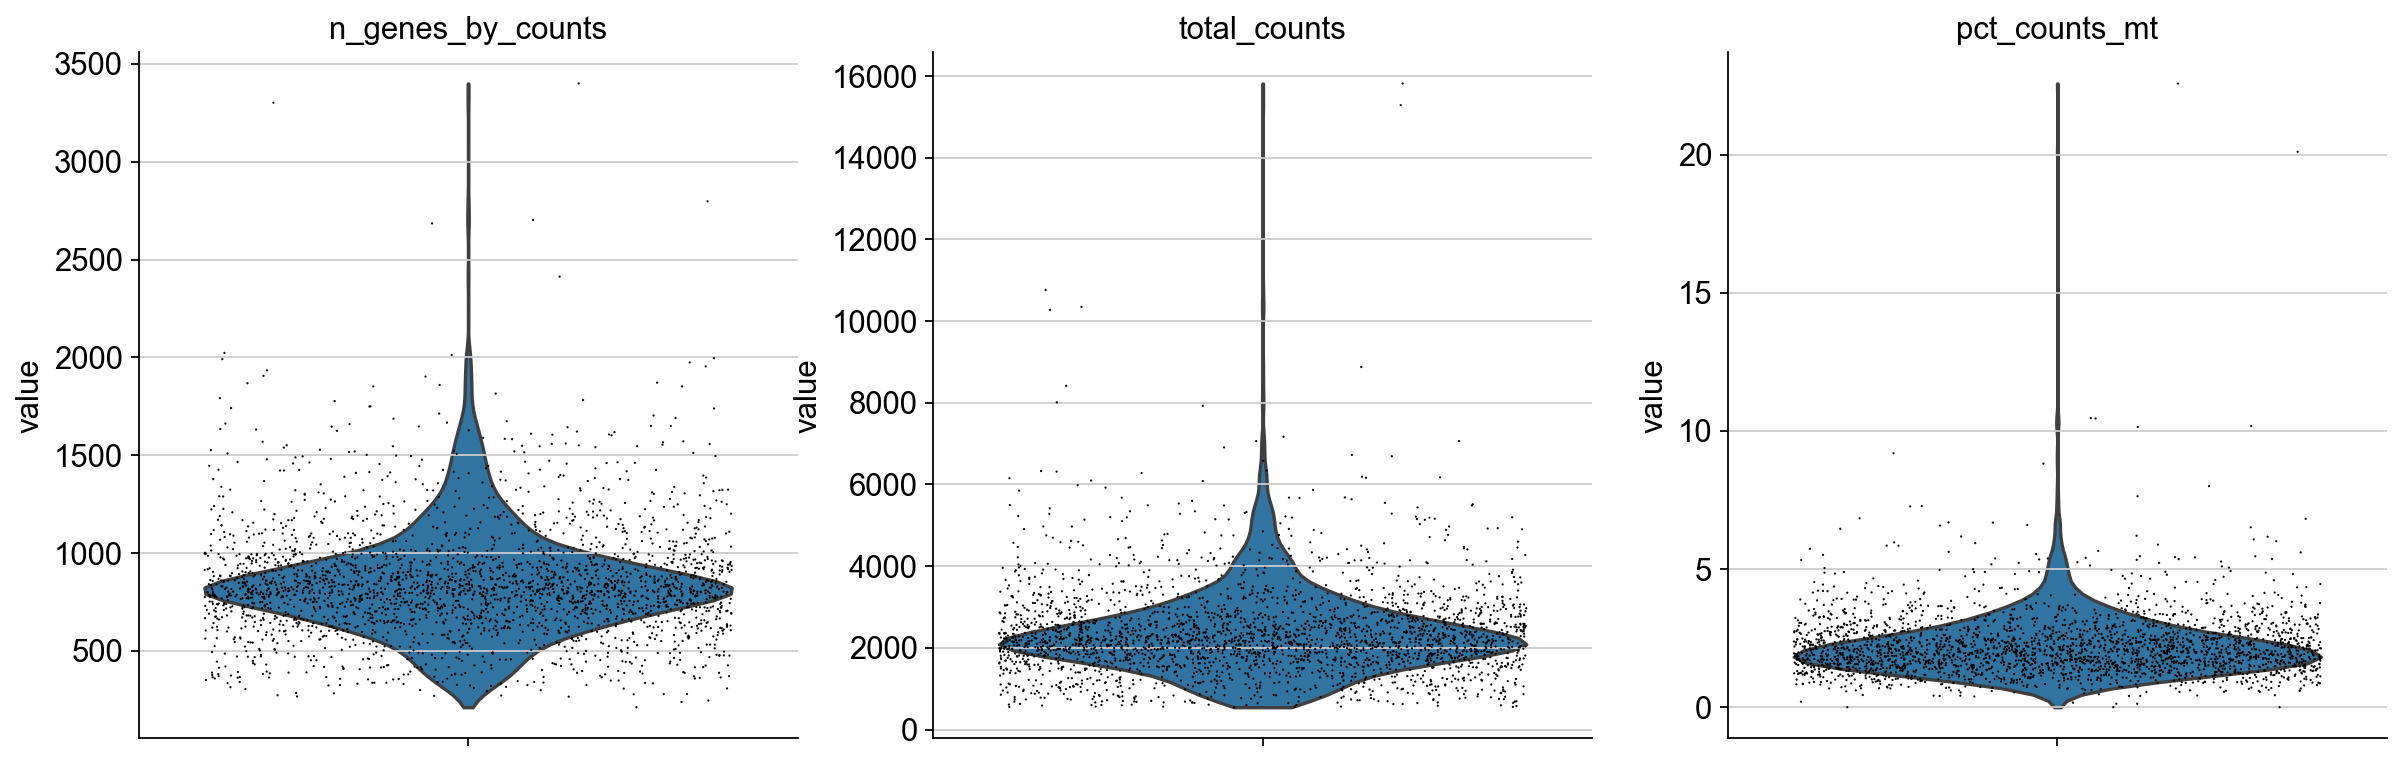

PBMC 10k (v3) :


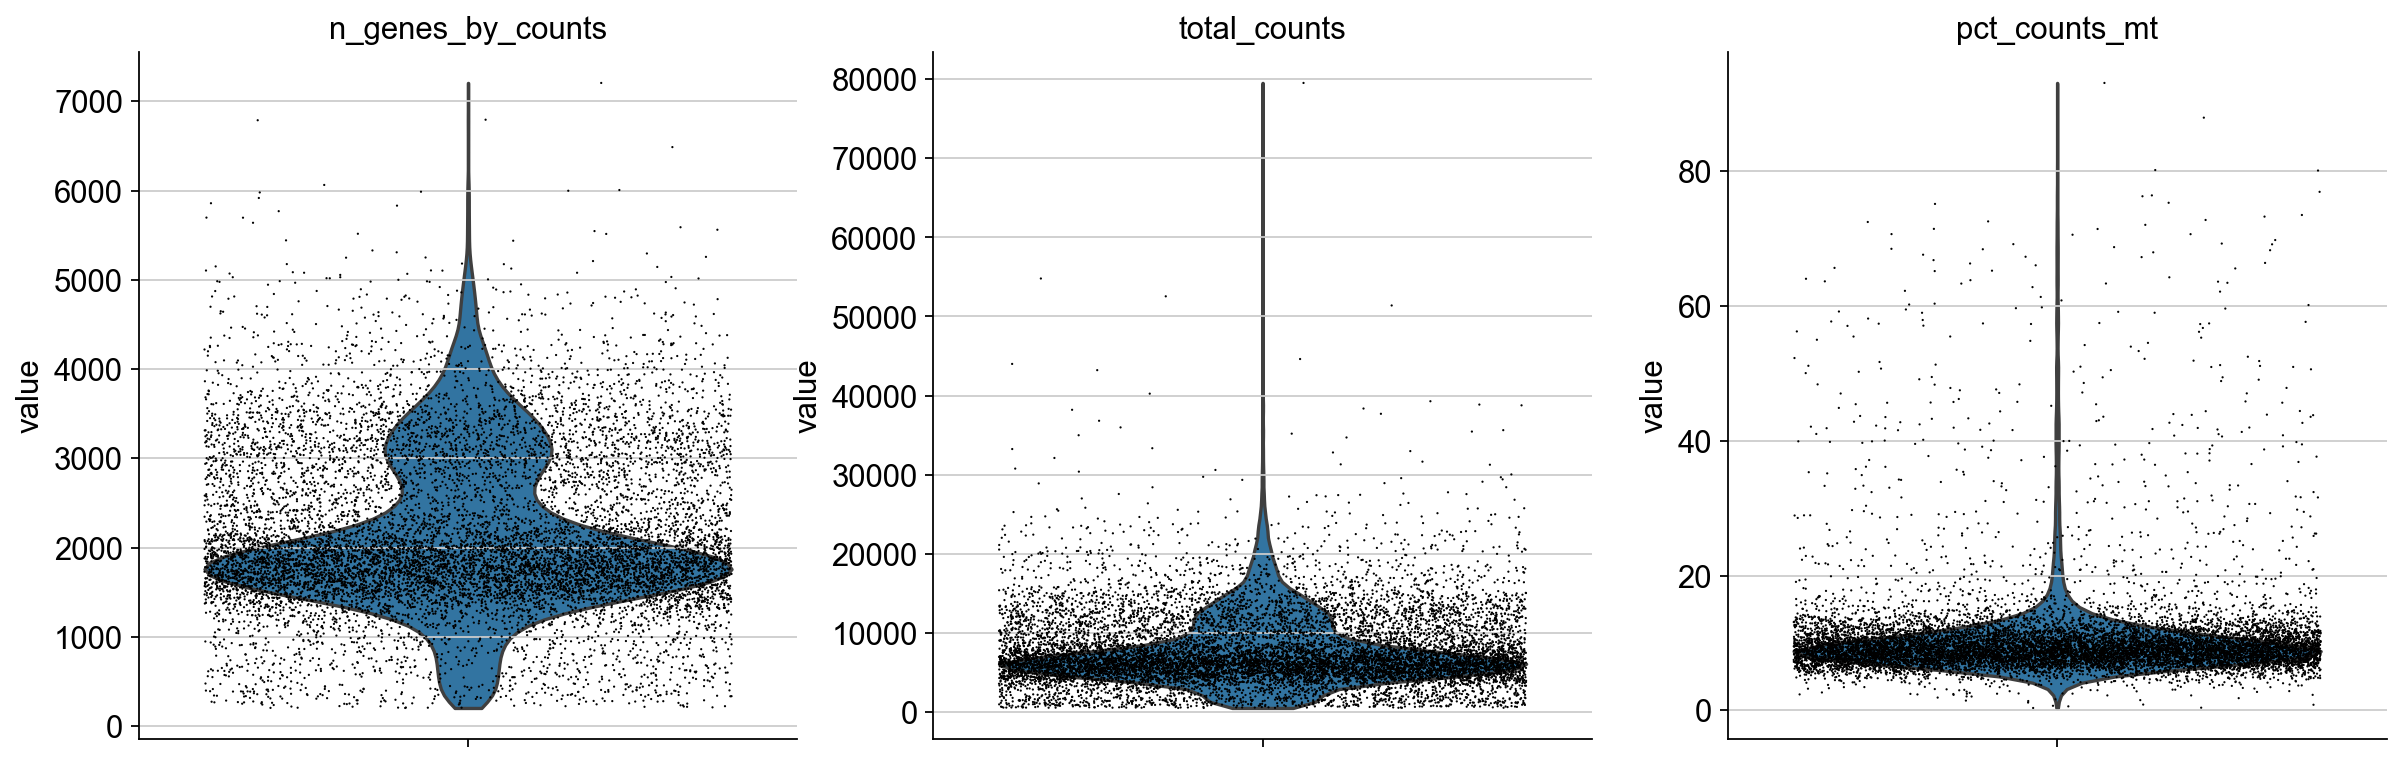

In [8]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    print(adata.uns["name"], ":")
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )

Based on these metrics, we define outlier cells and remove them. Afterwards, we make sure that all genes are at least detected once in the remaining cells.

In [9]:
# define outliers and do the filtering for the 3k dataset
adata_pbmc3k.obs['outlier_mt'] = adata_pbmc3k.obs.pct_counts_mt > 5
adata_pbmc3k.obs['outlier_total'] = adata_pbmc3k.obs.total_counts > 5000
adata_pbmc3k.obs['outlier_ngenes'] = adata_pbmc3k.obs.n_genes_by_counts > 2500

print('%u cells with high %% of mitochondrial genes' % (sum(adata_pbmc3k.obs['outlier_mt'])))
print('%u cells with large total counts' % (sum(adata_pbmc3k.obs['outlier_total'])))
print('%u cells with large number of genes' % (sum(adata_pbmc3k.obs['outlier_ngenes'])))

adata_pbmc3k = adata_pbmc3k[~adata_pbmc3k.obs['outlier_mt'], :]
adata_pbmc3k = adata_pbmc3k[~adata_pbmc3k.obs['outlier_total'], :]
adata_pbmc3k = adata_pbmc3k[~adata_pbmc3k.obs['outlier_ngenes'], :]
sc.pp.filter_genes(adata_pbmc3k, min_cells=1)

57 cells with high % of mitochondrial genes
69 cells with large total counts
5 cells with large number of genes
filtered out 2 genes that are detected in less than 1 cells


In [10]:
# define outliers and do the filtering for the 10k dataset
adata_pbmc10k.obs['outlier_mt'] = adata_pbmc10k.obs.pct_counts_mt > 20
adata_pbmc10k.obs['outlier_total'] = adata_pbmc10k.obs.total_counts > 25000
adata_pbmc10k.obs['outlier_ngenes'] = adata_pbmc10k.obs.n_genes_by_counts > 6000

print('%u cells with high %% of mitochondrial genes' % (sum(adata_pbmc10k.obs['outlier_mt'])))
print('%u cells with large total counts' % (sum(adata_pbmc10k.obs['outlier_total'])))
print('%u cells with large number of genes' % (sum(adata_pbmc10k.obs['outlier_ngenes'])))

adata_pbmc10k = adata_pbmc10k[~adata_pbmc10k.obs['outlier_mt'], :]
adata_pbmc10k = adata_pbmc10k[~adata_pbmc10k.obs['outlier_total'], :]
adata_pbmc10k = adata_pbmc10k[~adata_pbmc10k.obs['outlier_ngenes'], :]
sc.pp.filter_genes(adata_pbmc10k, min_cells=1)

494 cells with high % of mitochondrial genes
75 cells with large total counts
6 cells with large number of genes
filtered out 1 genes that are detected in less than 1 cells


## Use Pearson residuals for selection of highly variable genes

Analytic Pearson residuals can be used to identify biologically variable genes. For that, the observed counts are compared to the expected counts of a "null model". This model includes no biological variability between cells. Pearson residuals are defined such that genes that are not differentially expressed will have variance close to 1. In contrast, if a gene is differentially expressed, it will deviate from the null model, causing larger residuals and residual variance >1 for this gene. More details and comparisons to other gene selection methods can be found in [Lause et al. (2021)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7).

The call to `highly_variable_genes(flavor='pearson_residuals',n_top_genes=2000)` computes the residual variances and selects 2000 genes based on this. As shown in the plots below, cell type marker genes known *a priori* are successfully selected.



#### Compute 2000 variable genes with Pearson residuals

This will create the field `highly_variable`, indicating the 2000 genes that have the most variable Pearson residuals.

In [11]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=2000
    )

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


#### Plot gene selection

To illustrate the selection procedure, we plot mean and residual variance of each gene, highlighting the selected genes (red). On top, we plot the known marker genes defined in the beginning (black). We can see that all of them are selected, as desired.

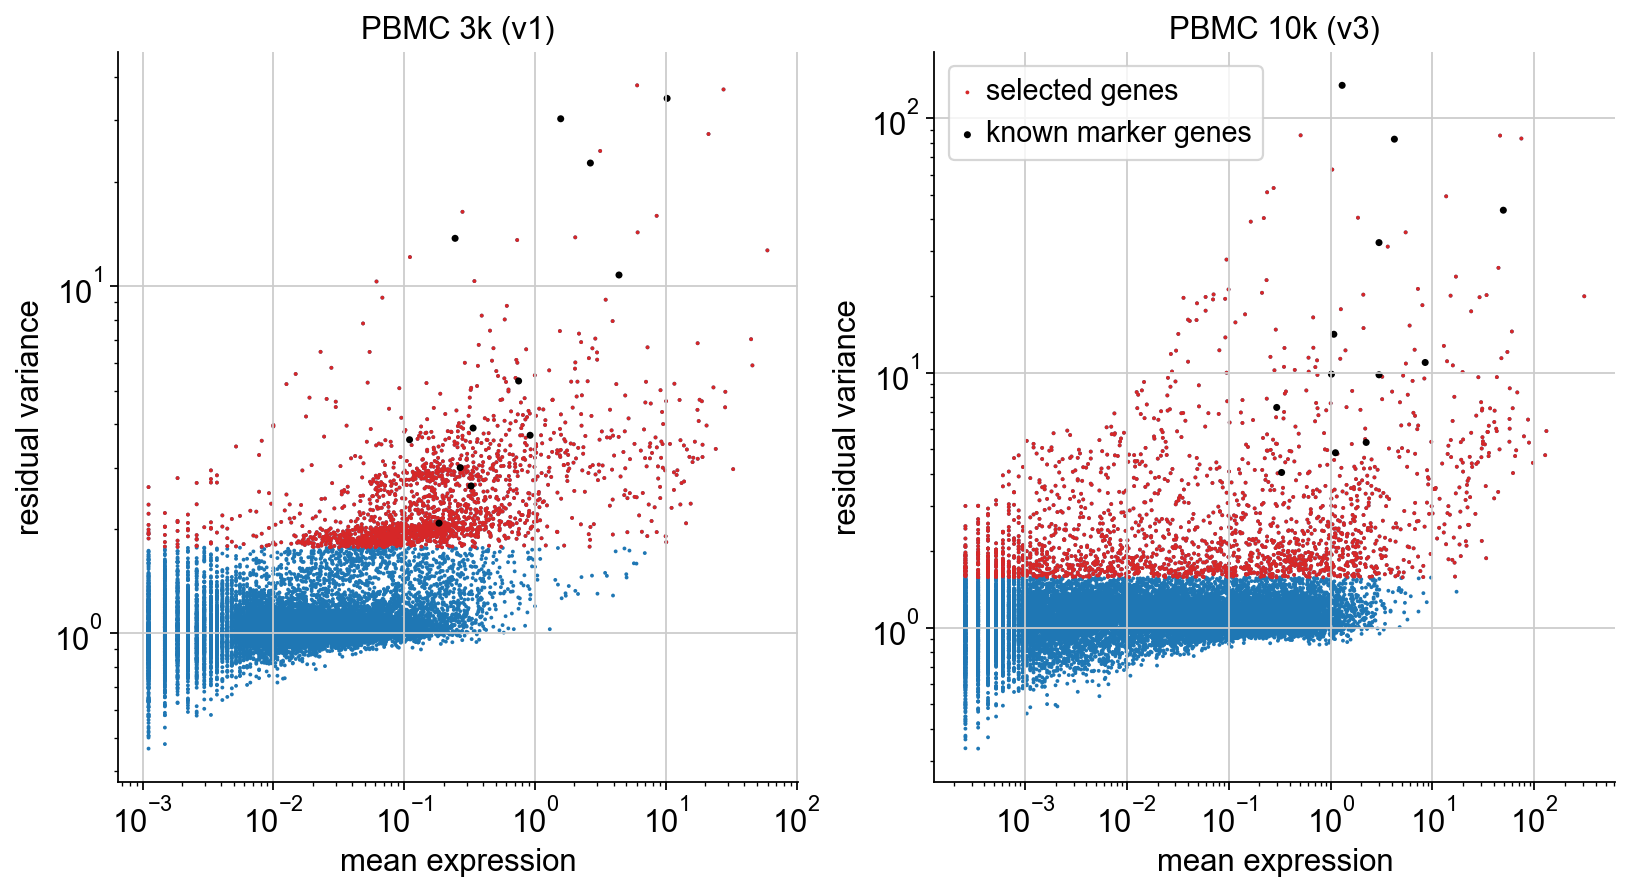

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, adata in zip(axes, [adata_pbmc3k, adata_pbmc10k]):

    hvgs = adata.var["highly_variable"]

    ax.scatter(
        adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none"
    )
    ax.scatter(
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
    )
    ax.scatter(
        adata.var["mean_counts"][np.isin(adata.var_names, markers)],
        adata.var["residual_variances"][np.isin(adata.var_names, markers)],
        c="k",
        label="known marker genes",
        s=10,
        edgecolor="none",
    )
    ax.set_xscale("log")
    ax.set_xlabel("mean expression")
    ax.set_yscale("log")
    ax.set_ylabel("residual variance")
    ax.set_title(adata.uns["name"])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
plt.legend()

#### Apply gene selection

We subset both datasets to retain just the variable genes.

In [13]:
adata_pbmc3k = adata_pbmc3k[:, adata_pbmc3k.var["highly_variable"]]
adata_pbmc10k = adata_pbmc10k[:, adata_pbmc10k.var["highly_variable"]]

#### Print resulting `adata` objects

In [14]:
adata_pbmc3k

View of AnnData object with n_obs × n_vars = 2574 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'outlier_mt', 'outlier_total', 'outlier_ngenes'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'name', 'hvg'

In [15]:
adata_pbmc10k

View of AnnData object with n_obs × n_vars = 10968 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'outlier_mt', 'outlier_total', 'outlier_ngenes'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'name', 'hvg'

## Transforming raw counts to Pearson residuals


When computing Pearson residuals, the observed  UMI counts are compared to the expected counts of a "null model". This model includes only technical factors, but no biological differences between cells. We then only keep the deviations from this model, the *residuals*, as representation of the data.

This implicitly performs normalization by sequencing depth and variance stabilization: As the null model *expects* the technical sources of variance, they are removed from the data. In contrast, biological variance is preserved: The null model is designed not to predict biological differences between cells. As a result, it will deviate from the observed counts starkly whenever genes differ in their expression between subpopulations -- and produce *large* residuals in return. This will even work for genes that mark only small subpopulations. An example of detecting a rare subpopulation consisting of just 50 cells with Pearson residuals is presented in [Lause et al. (2021)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7).

As a result, the transformed data will show less technical variability, and biological signals from variable genes will be amplified. Therefore, downstream processing like PCA will be dominated by biological rather then technical variances. This is why it makes sense to use Pearson residuals as basis for downstream processing. 


After reducing the dataset to the most variable genes in the previous steps, we will now transform our raw counts to residuals by calling `normalize_pearson_residuals(adata)`. In our example pipeline, we then apply PCA to reduce the dataset to the most relevant dimensions. We visualize this reduced representation with t-SNE and perform Leiden clustering, which is again taken from the [PBMC3k tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

This is just one of many possible pipelines: After PCA, you could also use UMAP or other embeddings to inspect the data, and cluster the data with a different algorithm than Leiden.


#### Preparations

Because we will transform the raw data in `adata.X` to residuals in the next step, we first save a copy of the raw counts to `adata.layers['raw']`. Also, we save a depth-normalized and square-root transformed version of the data to `adata.layers['sqrt_norm']`, so we can use them for plotting normalized counts later. Further background on why to use the square-root transform here can be found in [Wagner (2020)](https://www.biorxiv.org/content/10.1101/770388v3.full).

In [16]:
#keep raw and depth-normalized counts for later
adata_pbmc3k.layers["raw"] = adata_pbmc3k.X.copy()
adata_pbmc3k.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_pbmc3k, inplace=False)["X"]
)

adata_pbmc10k.layers["raw"] = adata_pbmc10k.X.copy()
adata_pbmc10k.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_pbmc10k, inplace=False)["X"]
)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


#### Compute Pearson residuals
This will transform the sparse raw counts in `adata.X` to a dense matrix of Pearson residuals

In [17]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.experimental.pp.normalize_pearson_residuals(adata)

computing analytic Pearson residuals on adata.X
    finished (0:00:00)
computing analytic Pearson residuals on adata.X
    finished (0:00:00)


#### Compute PCA and t-SNE
We now reduce the dimensionality of the data by running PCA on the Pearson residuals. On top, we run t-SNE for vizualisation.

In [18]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.pp.pca(adata, n_comps=50)
    n_cells = len(adata)
    sc.tl.tsne(adata, use_rep="X_pca")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:11)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:04)


#### Compute Neighborhood graph and Leiden clustering

Based on the PCA of Pearson resisuals, we also run a clustering.

In [19]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
    sc.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


#### Plot Leiden clusters on tSNE and PBMC marker genes

Now, we show the clustering results on top of the t-SNE. Finally, we also show the normalized counts of each marker gene on the same t-SNE. This demonstrates that the clusters found in the Pearson residuals + PCA data representation coincides with 'islands' of known markers.

PBMC 3k (v1) :


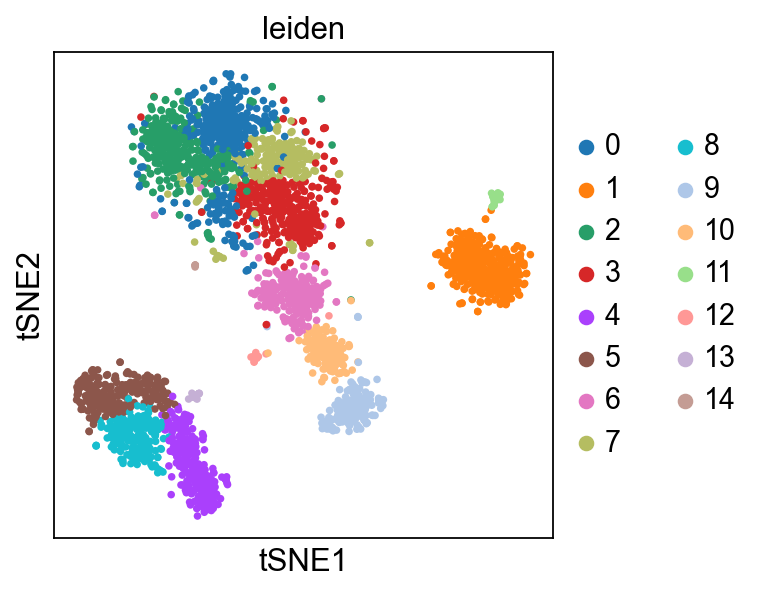

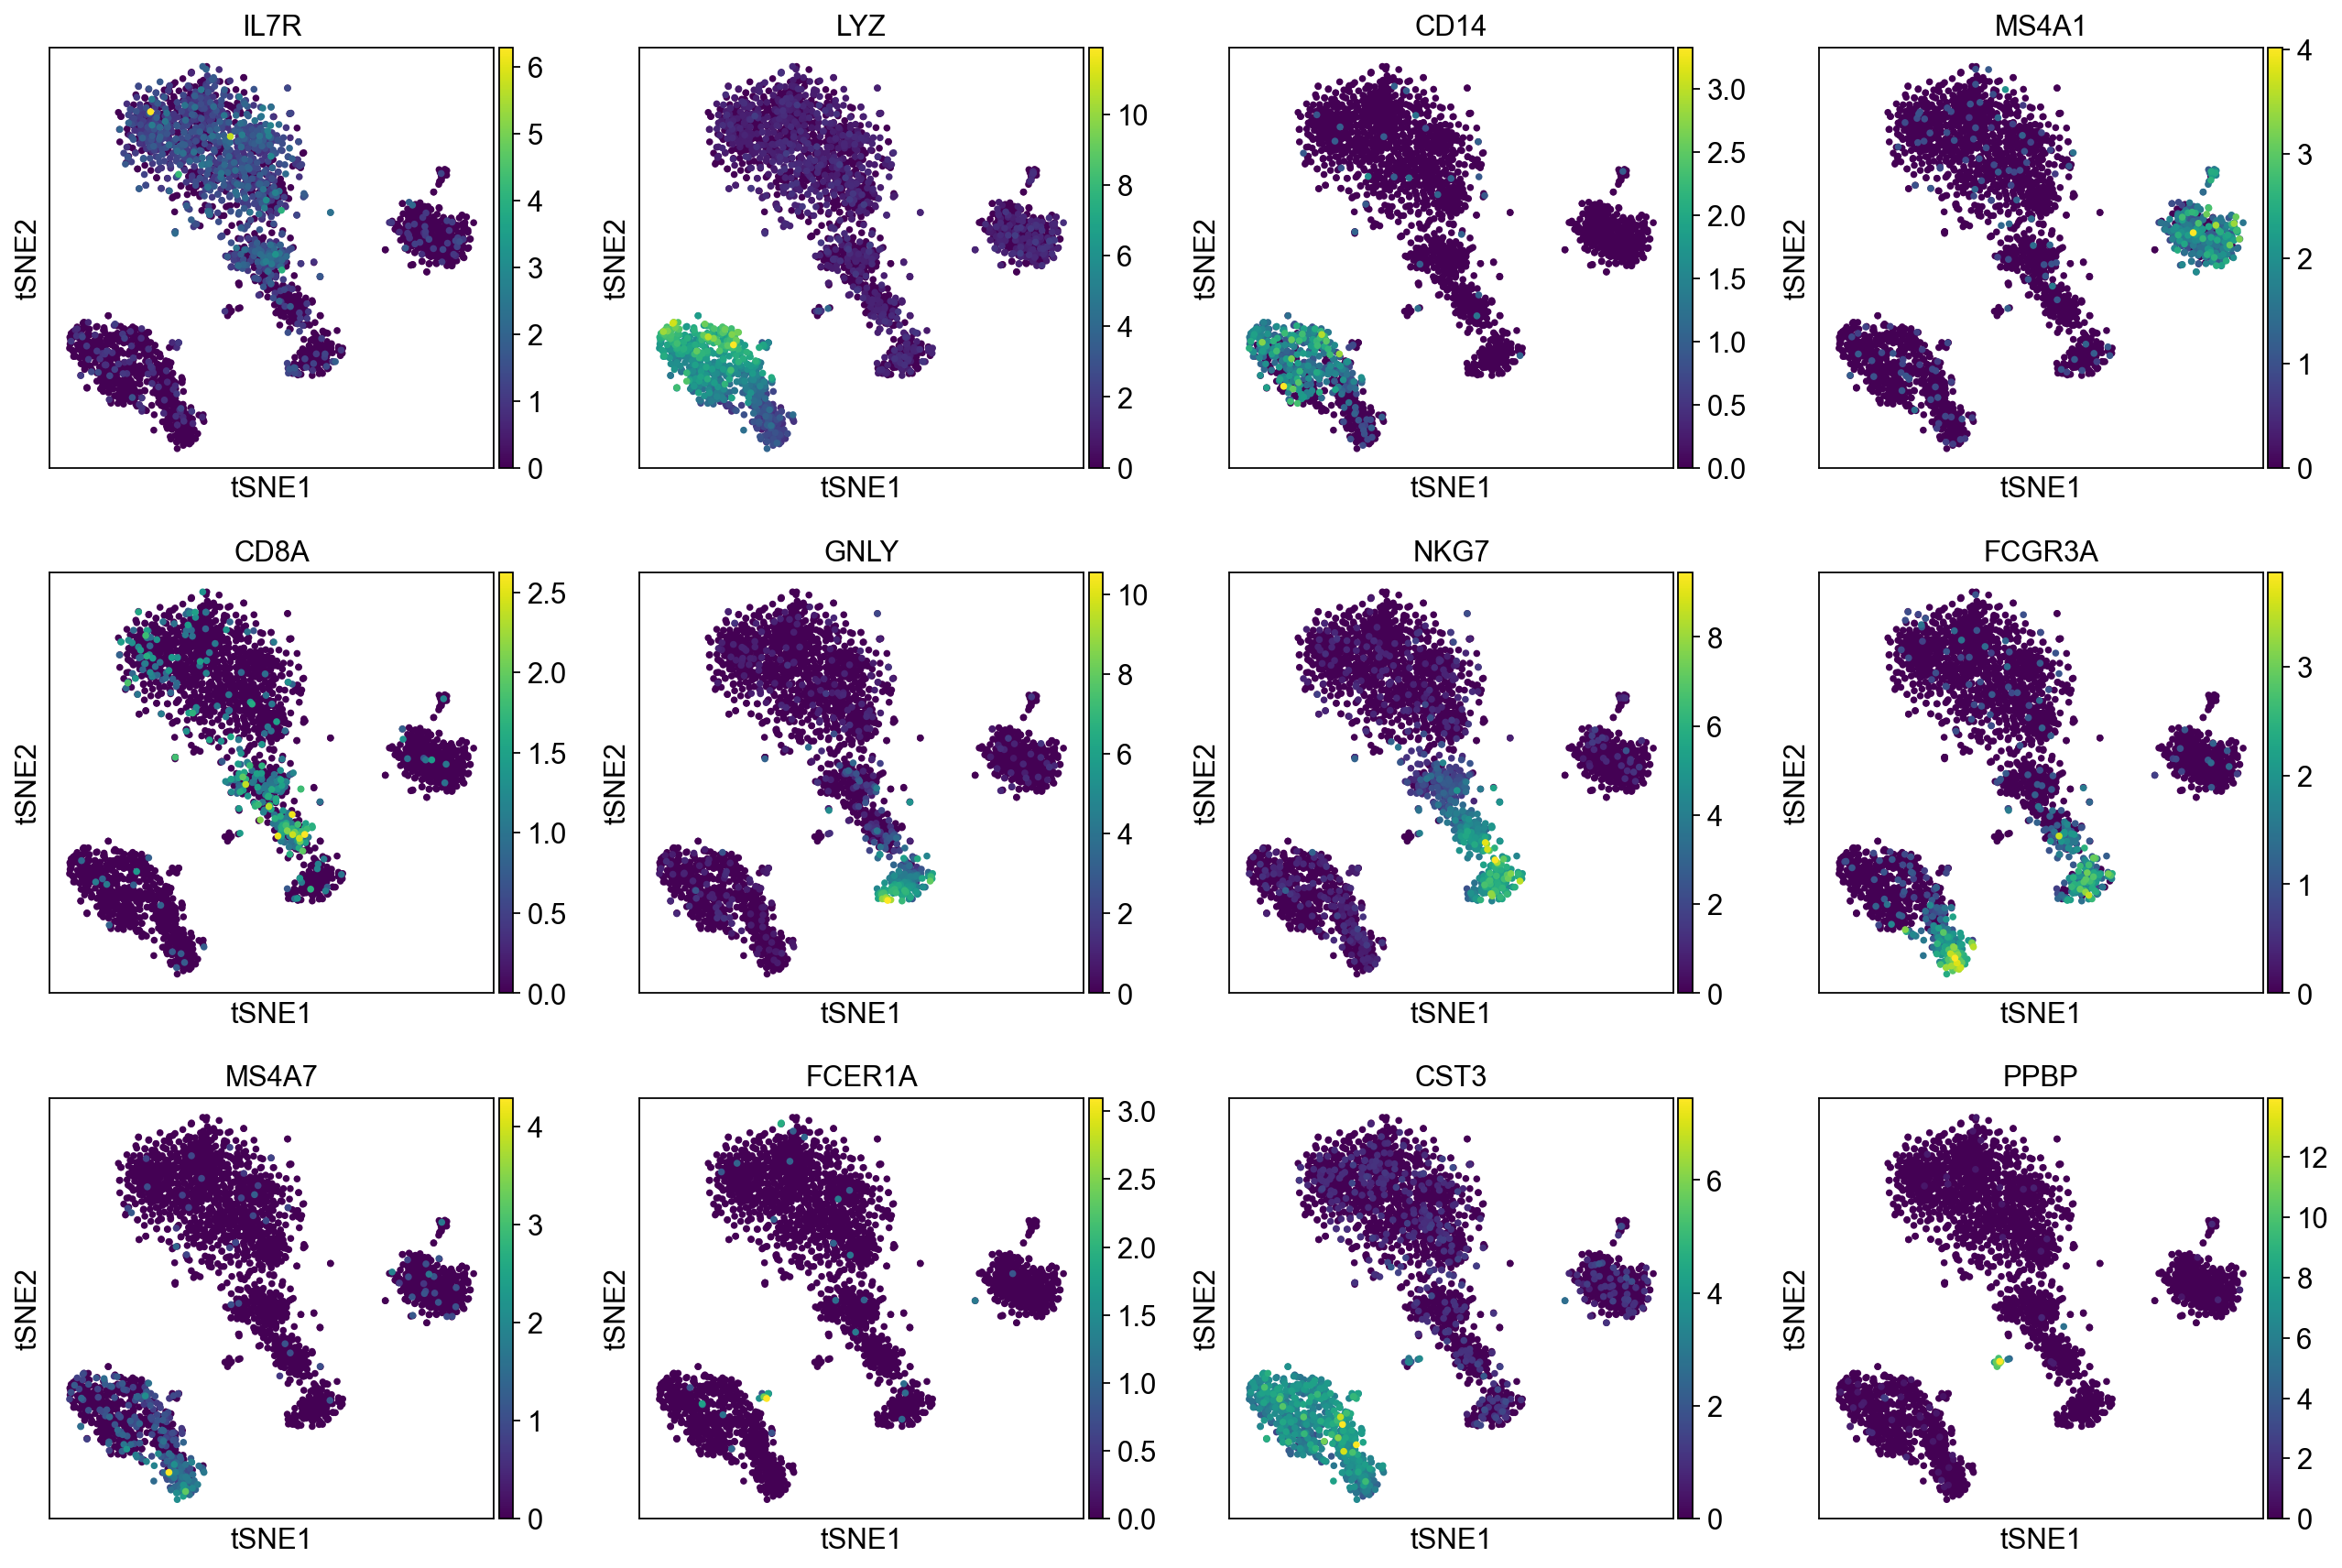

PBMC 10k (v3) :


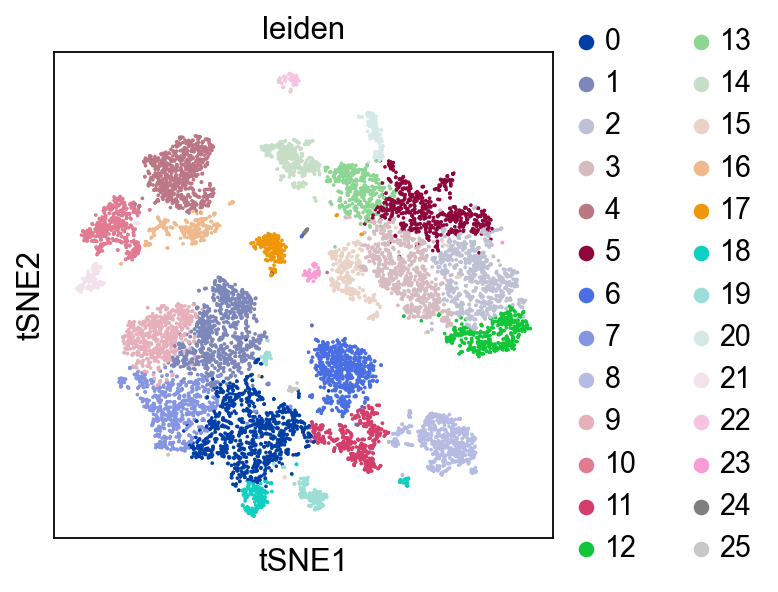

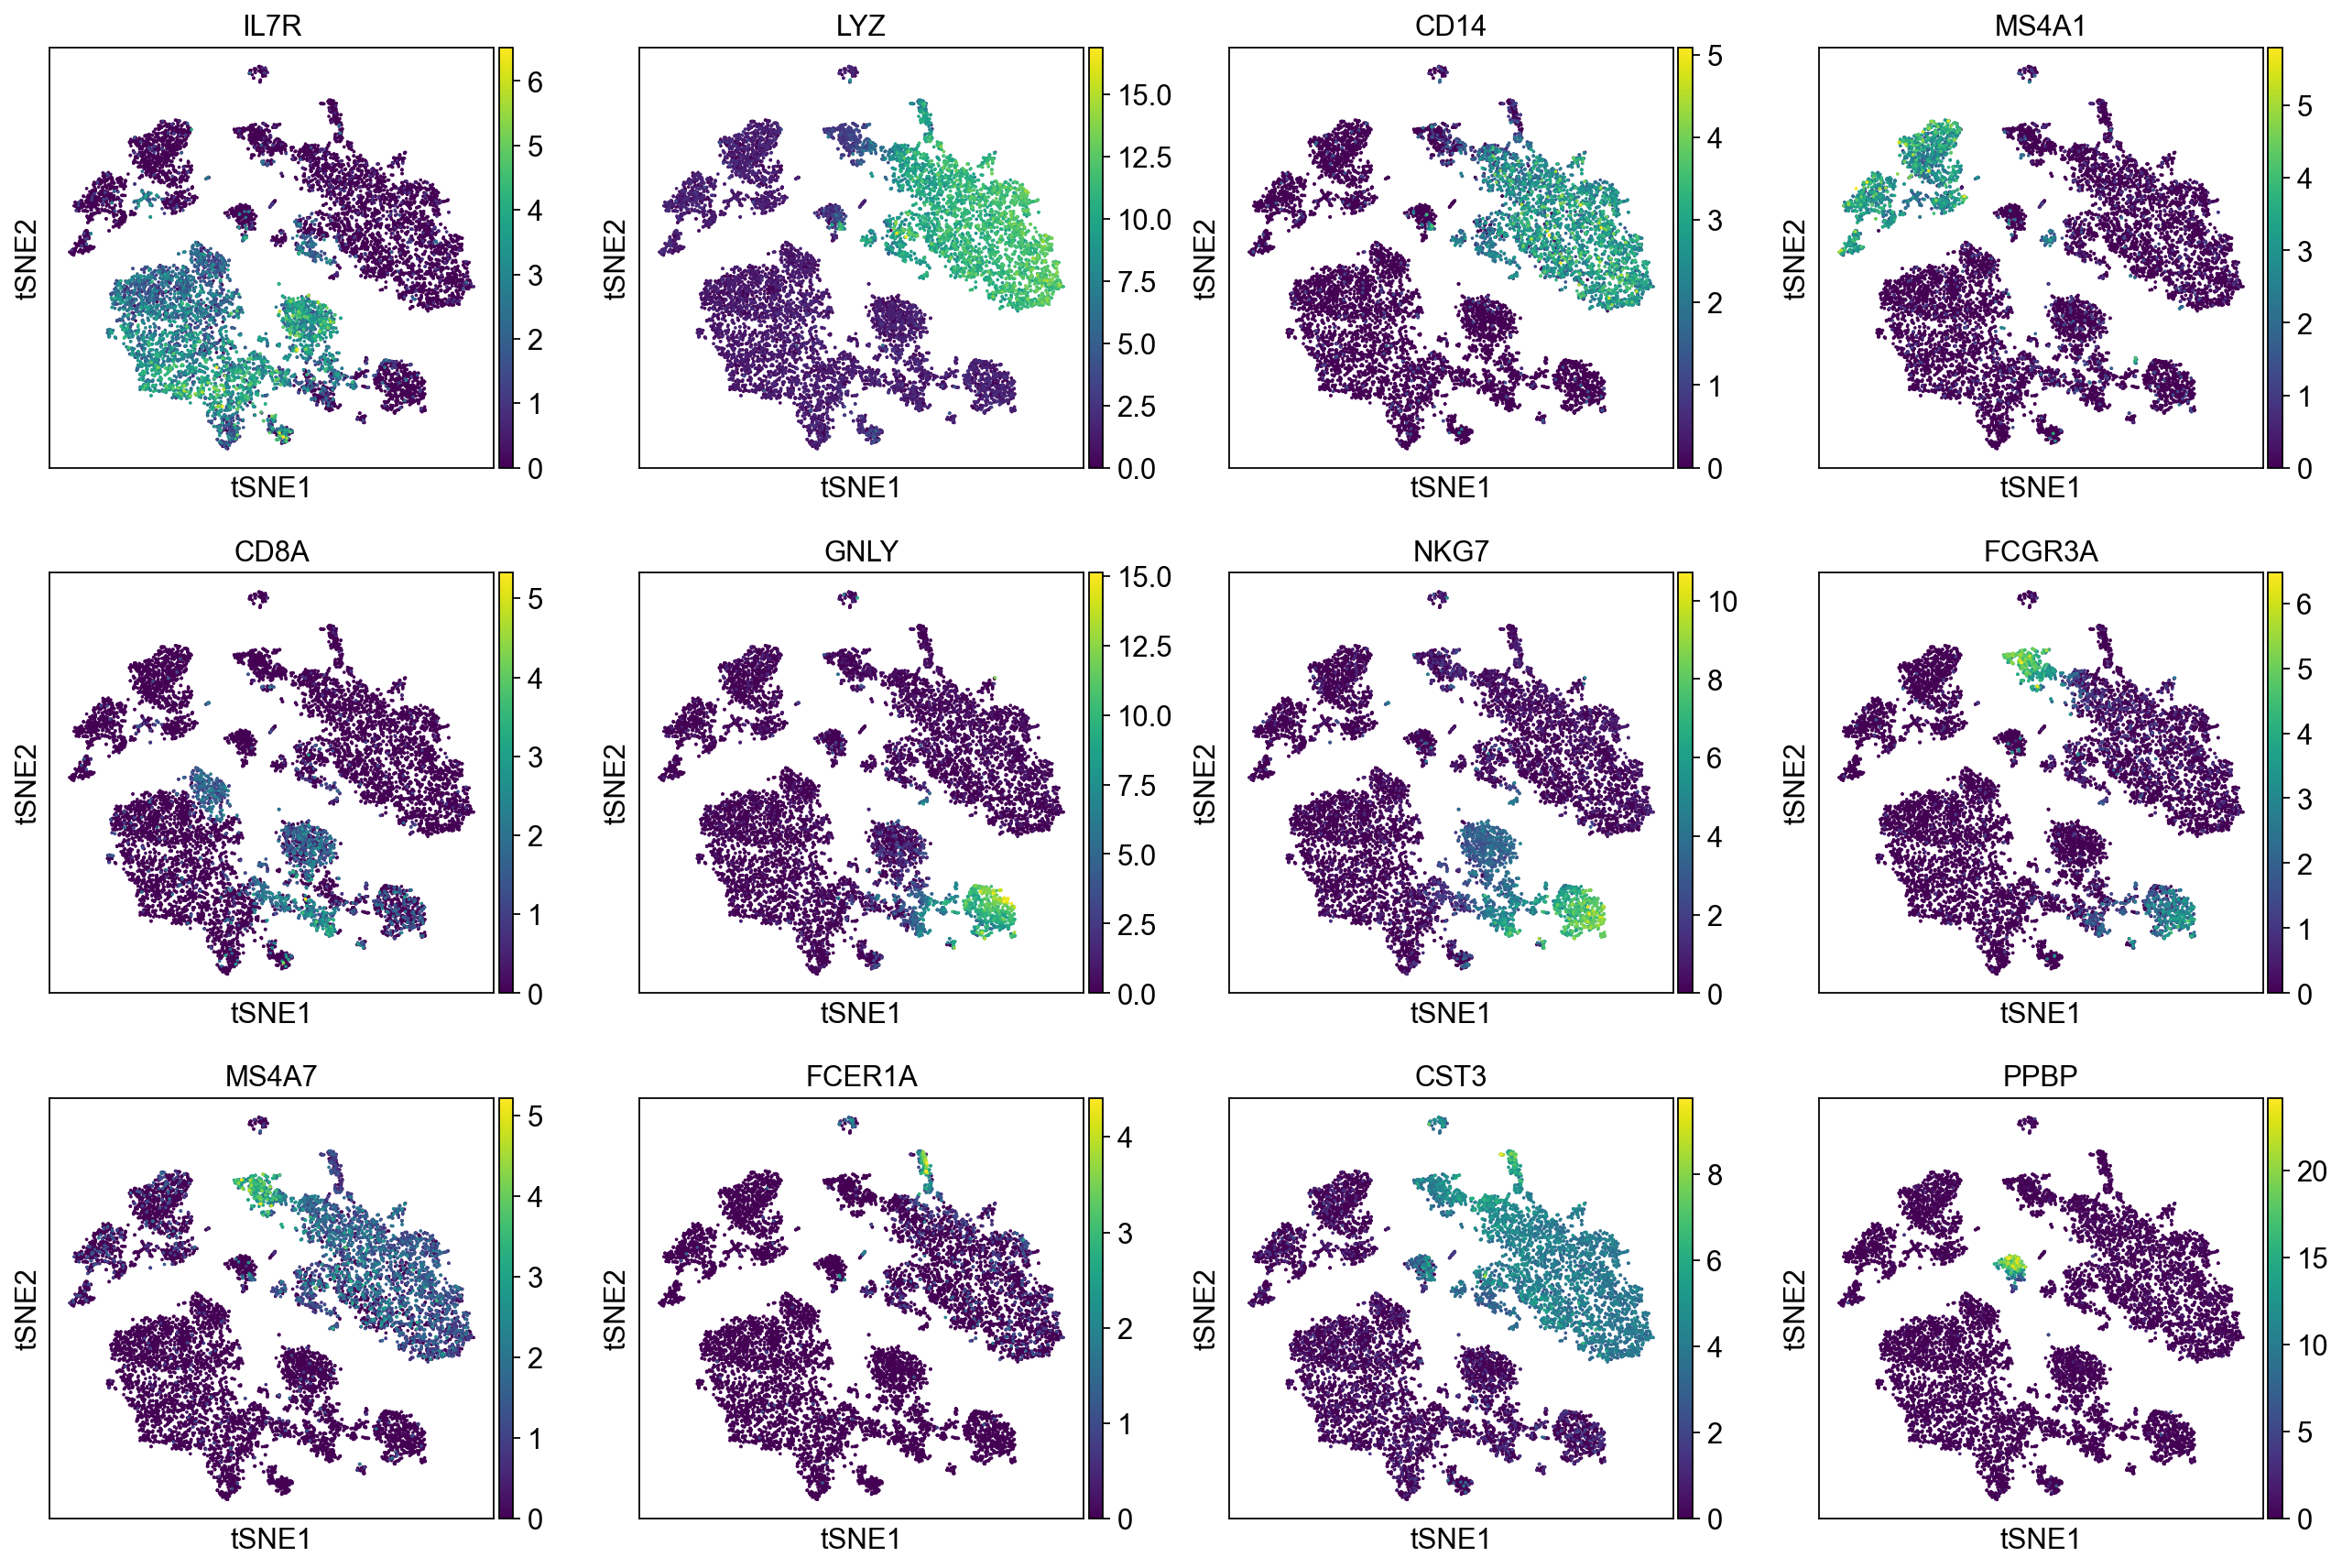

In [20]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    print(adata.uns["name"], ":")
    sc.pl.tsne(adata, color=["leiden"], cmap="tab20")
    sc.pl.tsne(adata, color=markers, layer="sqrt_norm")

## Optional input arguments

The functions to compute analytic Pearson residuals have up to three optional arguments besides the raw counts:

#### Overdispersion parameter `theta` 

To compute Pearson residuals, we need an estimation of the technical variance in the data. There is still a debate on which noise distribution is most appropiate for scRNA UMI data, with Poisson or the Negative binomial being likely candidates. We implemented the negative binomial model here, which is overdispersed compared to Poisson. The amount of overdispersion is controlled by the argument `theta`, where a smaller `theta` corresponds to larger overdispersion. [Lause et al. (2021)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7) recommend using the default `theta=100`, as noise in negative control data without biological variation was fit well by this value. If Poisson behavior is desired, the overdispersion parameter can instead be set to infinity (`theta=np.Inf`).

#### Clipping threshold `clip`

When a gene is expressed in only very few cells, and missing in all others, it will generate very large residuals for these few cells. In turn, these cells might dominate in downstream processing. To avoid such unbalanced behavior, [Hafemeister & Satija (2019)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) introduced a heuristic that clips all residuals to `+-sqrt(n_cells)`. This is the default behavior of all functions for Pearson residuals discussed here. If desired, a different threshold can be set using the `clip` argument. If no clipping is desired, use `clip=np.Inf`.

#### `chunksize` and best practice to obtain Pearson residuals for large datasets

Raw scRNA UMI counts are usually sparse, and can thus be stored efficiently for large datasets. However, when the count matrix is transformed to Pearson residuals, the data becomes dense. To avoid memory problems, we recommend that you reduce the size of your count matrix by gene selection, before running `normalize_pearson_residuals(adata)` on the reduced data. To perform RAM-efficient gene selection, use `highly_variable_genes(adata,flavor='pearson_residuals')` with the `chunksize` argument: This will still use Pearson residual variance to identify variable genes, but won't compute all residuals at once. Reduce the `chunksize` as needed if you run into RAM issues during gene selection. Note that a very small chunksize will slow down the computation, so try to set it as large as possible with your resources.

As an example, we used `chunksize=1000` when processing a dataset with 2 million cells in a machine with 500 GB RAM. For smaller machines, we would recommend to reduce this below 100.

## Wrapper functions for Pearson residuals preprocessing

The `scanpy.experimental.pp` module also ships two wrappers that run multiple pre-processing steps at once:

- `sc.experimental.pp.normalize_pearson_residuals_pca()` performs normalization by Pearson residuals and PCA in one go. This function is helpful to quickly obtain a Pearson residual-based data representation when highly variable genes are already defined, as only those are used by default.

- `sc.experimental.pp.recipe_pearson_residuals()` performs gene selection and normalization by Pearson residuals, and PCA on top. This is intended to make the full Pearson residual preprocessing available in one step.

All hyperparameters of the individual steps can still be controlled using the wrapper functions' arguments. See the documentation for details.

## References / See also

Hafemeister & Satija (2019), *Normalization and variance stabilization of single-cell RNA-seq data using regularized negative binomial regression*, [Genome Biology](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)

Lause et al. (2021), *Analytic Pearson residuals for normalization of single-cell RNA-seq UMI data*, [Genome Biology](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7)

Wagner (2021), *Normalization methods for single-cell RNA-Seq data*, [Youtube](https://www.youtube.com/watch?v=huxkc2GH4lk&t=2s)

Choudhary & Satija (2022), *Comparison and evaluation of statistical error models for scRNA-seq*, [Genome Biology](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02584-9)